# TensorFlow Datasets (TFDS)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import 

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

The tf.data API enables you to build complex input pipelines. The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.


Have a look at the official documentation at https://www.tensorflow.org/guide/data





## There are two distinct ways to create a dataset

> A data source constructs a Dataset from data stored in memory or in one or more files.




In [14]:
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).
batch_size = 128

# Get the data in form of numpy array
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

For instance, to construct a Dataset from data in memory, we can use `tf.data.Dataset.from_tensors()`.

Then we:


1.   shuffle
2.   batch
3.   apply trasformations
4.   eventually set the [repeat](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat) method

Note on the `repeat()` method.

We must call `repeat()` of the dataset when intend to provide an infinite dataset, and we specify the number of steps to run. This will be used in the first scenario of model construction (see *Model building (the hard way)*).

On the contrary, when we leverage the `.fit()` method to train our model (see *Model building (the easy way)*)
we do not need to call `repeat()` on the dataset, since the number of steps to run, in relation to the chosen number of epoch, is automatically managed by such `.fit()` method


In [15]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size) #shuffle data and define one to be the batch - pipeline
#create dataset from tensor_slices

> A ready-to-use dataset.

In [16]:
(mnist_train, mnist_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
#ready to use dataset

`tf.data.Dataset` objects can be converted to `pandas.DataFrame` with tfds.as_dataframe to be visualized on Colab.

In [17]:
tfds.as_dataframe(mnist_train.take(4), ds_info)

,image,label
0,,4
1,,1
2,,0
3,,7


`tfds.show_examples` returns a matplotlib.figure

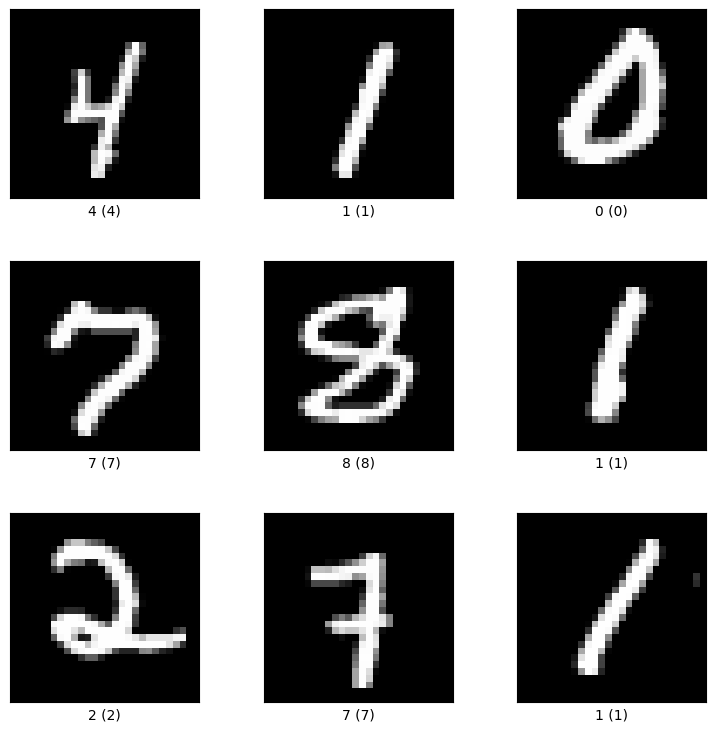

In [18]:
fig = tfds.show_examples(mnist_train, ds_info)

## Map method

When using the `Dataset.map` (and `Dataset.filter`) transformations we apply a function to each element of the `Dataset`. 
Then we batch and shuffle the `Dataset` and we levergae the call to `prefetch`.

This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

In [19]:
def process_data(image, label):
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label, 10, name='label', axis=-1)

mnist_train = mnist_train.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
mnist_train = mnist_train.cache()
mnist_train = mnist_train.shuffle(ds_info.splits['train'].num_examples)
mnist_train = mnist_train.batch(128)
mnist_train = mnist_train.prefetch(tf.data.AUTOTUNE)

mnist_test = mnist_test.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
mnist_test = mnist_test.cache()
mnist_test = mnist_test.batch(128)
mnist_test = mnist_test.prefetch(tf.data.AUTOTUNE)

# Apply a user define function to all the elements on the dataset, here a function is defined and we normalize our data and transform the label to be one of the encoded
# we do shuffle and batch, then prefetch is to avoid to process and then wait the loading.
# 

# Model building (the hard way)

Here we build a 2-hidden layers fully connected neural network leveraging a **low-level** approach to better understand all mechanics behind building neural networks and the training process.

In [20]:
# Network parameters.
n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 256 # 2nd layer number of neurons.

# Training parameters.
learning_rate = 0.1
training_steps = 2000
display_step = 100

# the hard way requires also the loop to update the weights

## Create TF Model

In [21]:
# create the model of the NN from keras model and set to dense (hidden) layer followed by the output ones
# this kind of model we need to define a call method that is called when we do forward or backward pass
# our model will take the input (both fully connected layers) and the output. This pipeline will be executed each time
class NeuralNet(tf.keras.Model):
    # Set layers.
    def __init__(self):
        super(NeuralNet, self).__init__()
        # First fully-connected hidden layer.
        self.fc1 = tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.relu)
        # Second fully-connected hidden layer.
        self.fc2 = tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.relu)
        # Output layer.
        self.out = tf.keras.layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
neural_net = NeuralNet()

## Metrics definition

In [22]:
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

'''
We have to define the metrics to see the performance of our model, using tensorflow. 
'''

'\nWe have to define the metrics to see the performance of our model, using tensorflow. \n'

## Optimization definition

In [24]:
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = neural_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = neural_net.trainable_variables #each variable has a SGD respect to the loss function

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables)) # apply the gradient
'''
SGD, mix of funciton defined by the user and function implemented in tensor flow. 
'''

'\nSGD, mix of funciton defined by the user and function implemented in tensor flow. \n'

## Run the training for the given number of steps.

In [25]:
'''
finally training over number of epoch. each time you take one element, then we run the optimizaiton and we print the accuracy. the pipeline in this way need to call the repeat method
because we have to look to our data more than once during the set
'''
# Run training
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 0.449530, accuracy: 0.859375
step: 200, loss: 0.283104, accuracy: 0.890625
step: 300, loss: 0.323976, accuracy: 0.906250
step: 400, loss: 0.189519, accuracy: 0.937500
step: 500, loss: 0.217351, accuracy: 0.937500
step: 600, loss: 0.208140, accuracy: 0.929688
step: 700, loss: 0.135547, accuracy: 0.960938
step: 800, loss: 0.173364, accuracy: 0.953125
step: 900, loss: 0.074025, accuracy: 0.984375
step: 1000, loss: 0.128382, accuracy: 0.945312
step: 1100, loss: 0.091689, accuracy: 0.968750
step: 1200, loss: 0.104672, accuracy: 0.976562
step: 1300, loss: 0.120082, accuracy: 0.976562
step: 1400, loss: 0.057302, accuracy: 0.992188
step: 1500, loss: 0.060812, accuracy: 0.984375
step: 1600, loss: 0.083507, accuracy: 0.984375
step: 1700, loss: 0.104437, accuracy: 0.976562
step: 1800, loss: 0.139262, accuracy: 0.960938
step: 1900, loss: 0.070206, accuracy: 0.984375
step: 2000, loss: 0.034167, accuracy: 1.000000


## Test and plot some predictions

In [26]:
# Test model on validation set.
pred = neural_net(x_test, is_training=False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.963600


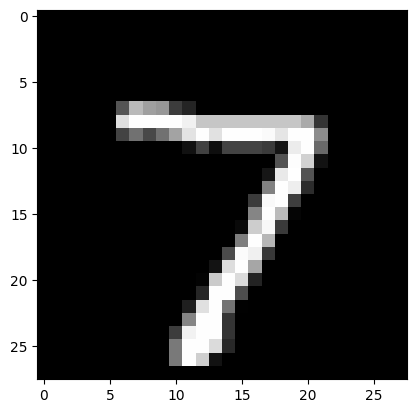

Model prediction: 7


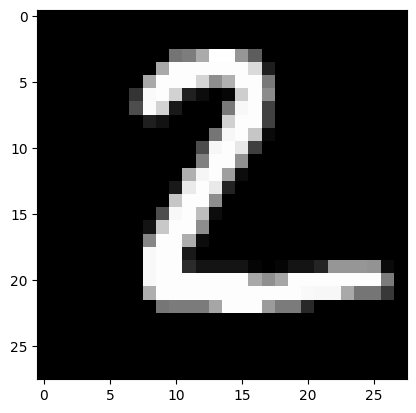

Model prediction: 2


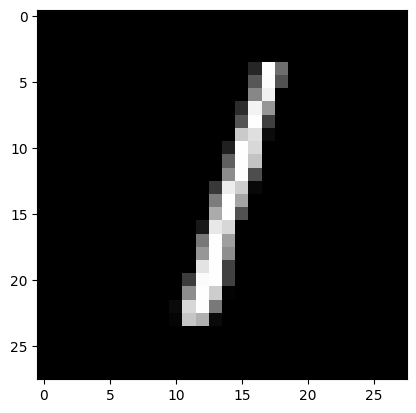

Model prediction: 1


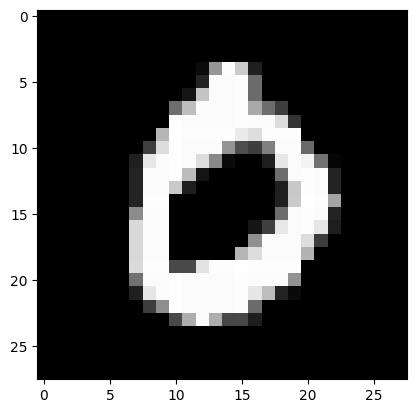

Model prediction: 0


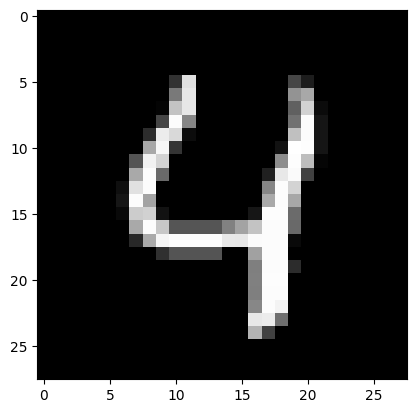

Model prediction: 4


In [27]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = neural_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))

# Model building (the easy way)

##  [Sequential model](https://keras.io/api/models/sequential/)

Note that, since we will now leverage a ready-to-use loss in tf (namely, tf.keras.losses.CategoricalCrossentropy()) we need to encode in one-hot the labels.

 Much convenient but less flexible. 

In [28]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(5000).batch(batch_size).prefetch(1)

In [29]:
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size).prefetch(1)

'''
same operation for test and training, but we dont shuffle the test
'''

In [31]:
def process_data(image, label):
    return image, tf.one_hot(label, 10, name='label', axis=-1)
'''
function over our image and labels. we performed the normalization of the numpy array before so no reason to do again, we transform the image in one_hot encoding.
'''

'\nfunction over our image and labels. we performed the normalization of the numpy array before so no reason to do again, we transform the image in one_hot encoding.\n'

In [32]:
train_data = train_data.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
model = tf.keras.models.Sequential()
# always use keras api to define the layers
model.add(tf.keras.layers.Dense(n_hidden_1, activation='relu'))
model.add(tf.keras.layers.Dense(n_hidden_2, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

## defining the optimiser and loss function
model.compile(optimizer=tf.optimizers.SGD(learning_rate),
              metrics="accuracy",
              loss=tf.keras.losses.CategoricalCrossentropy())

## training the model
model.fit(train_data,
          batch_size=128, #might be removed
          epochs=10)

Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 0.4476 - accuracy: 0.8749
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2131 - accuracy: 0.9388
Epoch 3/10
469/469 [==============================] - 2s 3ms/step - loss: 0.1603 - accuracy: 0.9541
Epoch 4/10
469/469 [==============================] - 2s 3ms/step - loss: 0.1294 - accuracy: 0.9624
Epoch 5/10
469/469 [==============================] - 2s 3ms/step - loss: 0.1086 - accuracy: 0.9682
Epoch 6/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0927 - accuracy: 0.9727
Epoch 7/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0810 - accuracy: 0.9762
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0711 - accuracy: 0.9789
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0635 - accuracy: 0.9814
Epoch 10/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0569 - accuracy: 0.9836

In [34]:
print(f"Accuracy: {model.evaluate(test_data)[1]:.2f}")

79/79 [==============================] - 0s 3ms/step - loss: 0.0894 - accuracy: 0.9722
Accuracy: 0.97


##[Model API (ex functional)](https://keras.io/api/models/model/#model-class)

In [35]:
input_layer = tf.keras.layers.Input(shape=(num_features))
layer_1 = tf.keras.layers.Dense(n_hidden_1, activation="relu")(input_layer)
layer_2 = tf.keras.layers.Dense(n_hidden_2, activation="relu")(layer_1)
output_layer= tf.keras.layers.Dense(num_classes, activation="softmax")(layer_2)

## Defining the model by specifying the input and output layers
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

## defining the optimiser and loss function
model.compile(optimizer=tf.optimizers.SGD(learning_rate),
              metrics="accuracy",
              loss=tf.keras.losses.CategoricalCrossentropy())

## training the model
history = model.fit(train_data,
                    batch_size=128,
                    epochs=10)
# in this way we define the network and the layers, and setup the model with this syntax (Model) that allows you to do a stack of layers

Epoch 1/10
469/469 [==============================] - 3s 4ms/step - loss: 0.4532 - accuracy: 0.8748
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: 0.2172 - accuracy: 0.9380
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1633 - accuracy: 0.9519
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1317 - accuracy: 0.9624
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1104 - accuracy: 0.9682
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0949 - accuracy: 0.9725
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0835 - accuracy: 0.9759
Epoch 8/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0734 - accuracy: 0.9787
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0657 - accuracy: 0.9808
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0587 - accuracy: 0.9828

In [36]:
print(f"Accuracy: {model.evaluate(test_data)[1]:.2f}")

79/79 [==============================] - 0s 3ms/step - loss: 0.0829 - accuracy: 0.9740
Accuracy: 0.97


# Assignment #1: making new Layers and Models via subclassing
You will build a ResNet18 architecture leveraging tf.keras.Model subclassing



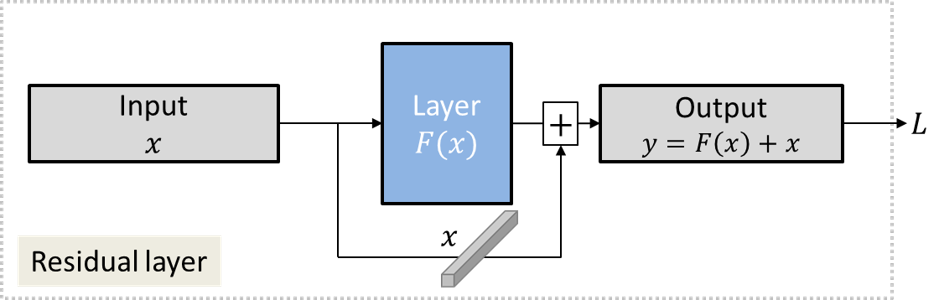

Notes:
*   **Batch normalization** is implemented right after each convolution and before activation
*   If the **input dimension has the same dimension as the output** the block implements an identity function 
*   **Otherwise** in the skip connection we insert a 1x1 convolutional block

In [37]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, 
            padding='same', 
            kernel_size=3, 
            strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, 
            kernel_size=3, 
            padding='same')
        self.conv_1x1 = None
        if use_1x1conv:
            self.conv_1x1 = tf.keras.layers.Conv2D(
                num_channels, 
                kernel_size=1, 
                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv_1x1 is not None:
            X=self.conv_1x1(X) # 1x1 convolution
        Y+=X # identity function
        return tf.keras.activations.relu(Y)

In [38]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, downscale=True,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and downscale:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

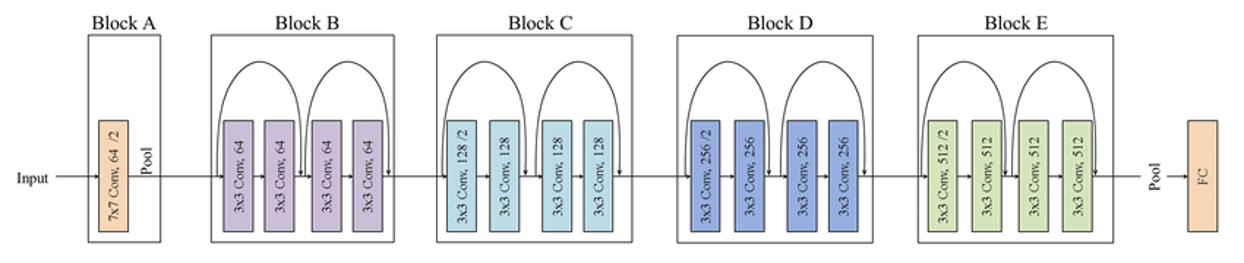

## ResNet18

In [39]:
class ResNet(tf.keras.Model):

    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64, 
                                    kernel_size=7, 
                                    strides=2, 
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3, 
                                       strides=2, 
                                       padding='same')])             
        self.block_b = ResnetBlock(64, 2, downscale=False)
        self.block_c = ResnetBlock(128, 2)
        self.block_d = ResnetBlock(256, 2)
        self.block_e = ResnetBlock(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.global_pool(x)
        return self.classifier(x)

# Assignment #2: the CIFAR-10
1. Load the CIFAR-10 from TFDS (see [here](https://www.tensorflow.org/datasets/catalog/cifar10))
2. Train and test your ResNet18 on such dataset


In [40]:
(cifar10_train, cifar10_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteWXVMYO/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteWXVMYO/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [41]:
def process_data(image, label):
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label, 10, name='label', axis=-1)

cifar10_train = cifar10_train.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_train = cifar10_train.cache()
cifar10_train = cifar10_train.shuffle(ds_info.splits['train'].num_examples)
cifar10_train = cifar10_train.batch(128)
cifar10_train = cifar10_train.prefetch(tf.data.AUTOTUNE)

cifar10_test = cifar10_test.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_test = cifar10_test.cache()
cifar10_test = cifar10_test.batch(128)
cifar10_test = cifar10_test.prefetch(tf.data.AUTOTUNE)

In [42]:
IMAGE_SIZE = 32
net = ResNet()
net.build((1, IMAGE_SIZE, IMAGE_SIZE, 3))
net.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
net.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
net.fit(cifar10_train, epochs=15)

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (1, 8, 8, 64)             9728      
                                                                 
 resnet_block (ResnetBlock)  multiple                  148736    
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 526976    
 )                                                               
                                                                 
 resnet_block_2 (ResnetBlock  multiple                 2102528   
 )                                                               
                                                                 
 resnet_block_3 (ResnetBlock  multiple                 8399360   
 )                                                               
                                                           

In [43]:
print("Accuracy on test set: {:.2f}".format(net.evaluate(cifar10_test)[1]))

79/79 [==============================] - 4s 42ms/step - loss: 1.8174 - accuracy: 0.6285
Accuracy on test set: 0.63
